In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, precision_score
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
train = pd.read_parquet('train_data.parquet')
test = pd.read_parquet('test_data.parquet')

X_train,y_train = train.drop(columns=["churn"]), train["churn"]
X_test,y_test = test.drop(columns=["churn"]), test["churn"]

In [ ]:
def churn_prediction(X_train, X_test, y_train, y_test):

    X_train = X_train.drop('id', axis=1)
    X_test = X_test.drop('id', axis=1)
    
    xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    n_jobs = -1,
    tree_method= 'hist',
    device= 'cuda',
    )

    param_dist = {
        'n_estimators': [3500],
        'max_depth': [4],
        'learning_rate': [0.1],
        "reg_lambda": [5],
        "reg_alpha": [5],
    }

    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=1,
        cv=3,
        scoring='roc_auc_ovr',
        verbose=1,
    )

    random_search.fit(X_train, y_train)
    
    print("Best Params: ", random_search.best_params_)

    best_model = random_search.best_estimator_
    
    #y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]  
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f'AUC Score: {auc_score:.2f}')

    return y_pred_proba


In [ ]:
y_pred_proba = churn_prediction(X_train, X_test, y_train, y_test)

In [25]:
y_pred_proba_series = pd.Series(y_pred_proba, name="Predicted_Prob")
y_test_series = pd.Series(y_test, name="Actual")

call_center_data = pd.concat([test["id"].reset_index(drop=True),y_pred_proba_series.reset_index(drop=True), y_test_series.reset_index(drop=True)], axis=1)

sorted_call_center_data = call_center_data.sort_values(by='Predicted_Prob', ascending=False)

top_1000 = sorted_call_center_data.head(1000)

precision = precision_score(top_1000['Actual'], (top_1000['Predicted_Prob'] > 0).astype(int))

print(f"Precision of top 1000 predictions: {precision}")

top_1000[top_1000["Actual"] == 1]

Precision of top 1000 predictions: 0.087


,id,Predicted_Prob,Actual
1864330,30b3b0b9-3fba-4e84-ba19-3d38db4ab4f7,0.209026,1
1862577,a403c121-28e7-441b-8835-193268e885cc,0.198256,1
138866,528e1ff5-af09-47cd-b60e-50cd43de1ec4,0.186080,1
812210,10b3f97b-fd39-420b-81d0-95caadd51a5b,0.180499,1
1584739,cbdeabf1-087c-4b3f-8a88-1366ff577578,0.178559,1
...,...,...,...
1669976,f8a49b08-e2ae-4643-868d-6d6982661c97,0.126846,1
592911,1ae4c9c7-2b57-48c5-9da6-e5ee884fa65a,0.126481,1
1831306,5f475c74-59ae-4d4f-90ae-3305cd4dee42,0.126370,1
309628,a899b7c0-5801-4afb-99f9-2b672a868733,0.126264,1


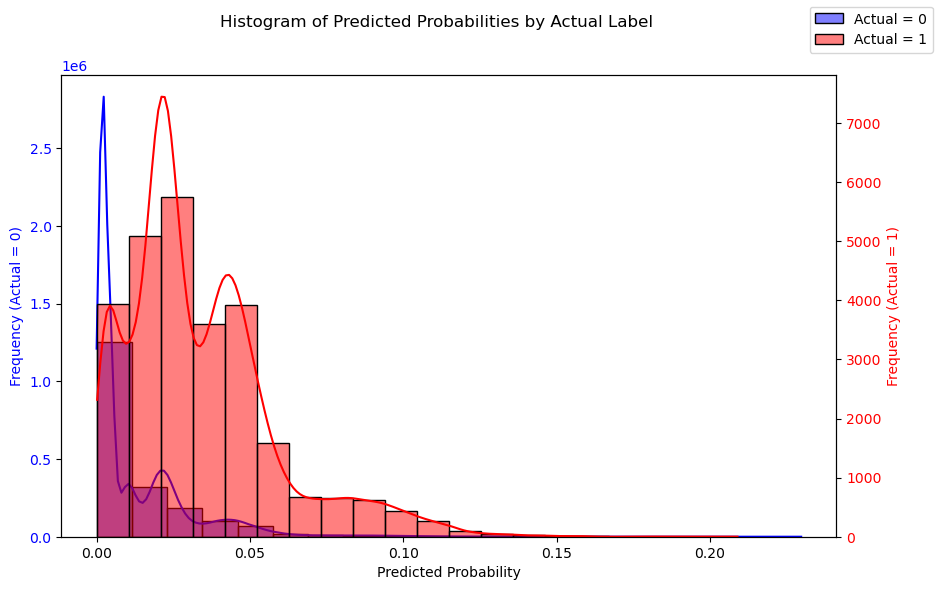

In [ ]:
data = call_center_data.copy()
prob_1 = data[data['Actual'] == 1]['Predicted_Prob']
prob_0 = data[data['Actual'] == 0]['Predicted_Prob']

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.histplot(prob_0, bins=20, color='blue', alpha=0.5, label="Actual = 0", kde=True, ax=ax1)
ax1.set_xlabel("Predicted Probability")
ax1.set_ylabel("Frequency (Actual = 0)", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

ax2 = ax1.twinx()

sns.histplot(prob_1, bins=20, color='red', alpha=0.5, label="Actual = 1", kde=True, ax=ax2)
ax2.set_ylabel("Frequency (Actual = 1)", color="red")
ax2.tick_params(axis='y', labelcolor="red")

fig.suptitle("Histogram of Predicted Probabilities by Actual Label")
fig.legend(loc="upper right")

plt.show()

In [14]:
top_1000

,id,Predicted_Prob,Actual
12835,16cac223-d2f7-41d1-99ee-e4252dc60500,0.229804,0
1235206,b7844557-52be-4e37-9bc2-df6c9711428c,0.223407,0
1864330,30b3b0b9-3fba-4e84-ba19-3d38db4ab4f7,0.209026,1
520018,8ac3cbf8-448d-4205-b385-81fe31a79933,0.206956,0
789556,9e7d6195-5f95-426c-a691-b3f1ba64425e,0.206910,0
...,...,...,...
1522141,bd25238b-4c9f-41b2-9107-23a605a104f1,0.125933,0
920402,0aa6c224-fe13-4e58-80ca-6a2919c522c8,0.125918,0
886530,bdd1203c-6900-4241-9b79-c739e5fb679b,0.125906,0
307286,4a47ef64-d7b6-447c-8cc3-88710bf546ef,0.125902,1


c:\Users\Kutay\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


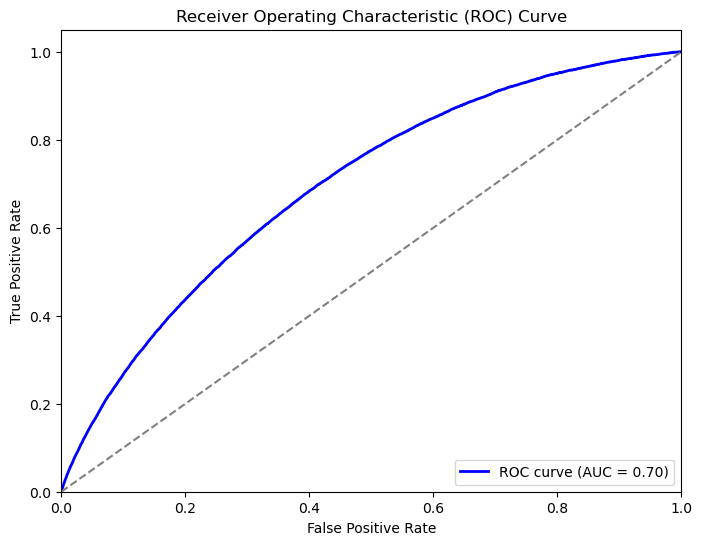

                   Feature  Coefficient  Odds Ratio
6         overdue_payments     0.186090    1.204531
17                postpaid     0.170268    1.185623
9               call_drops     0.005113    1.005127
2        avg_call_duration    -0.000161    0.999839
5           monthly_charge    -0.000284    0.999716
4            roaming_usage    -0.000400    0.999600
8         avg_top_up_count    -0.000451    0.999549
1                   tenure    -0.001500    0.998501
3               data_usage    -0.002757    0.997247
10  customer_support_calls    -0.024788    0.975517
15              hizlipazar    -0.038173    0.962547
14                 cuzdanx    -0.038933    0.961815
0                      age    -0.057194    0.944411
12                  izlego    -0.107057    0.898474
11      satisfaction_score    -0.152458    0.858595
13                 ritimgo    -0.289117    0.748925
16               konusalim    -0.461677    0.630226
7             auto_payment    -0.603459    0.546917
18          

In [15]:
def logistic_regression(X_train, X_test, y_train, y_test):

    X_train = X_train.drop('id', axis=1)
    X_test = X_test.drop('id', axis=1)
    
    log_reg = LogisticRegression(max_iter=200, solver='saga', n_jobs=-1, penalty="elasticnet", l1_ratio=0.5)    
    
    log_reg.fit(X_train, y_train)
    
    y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    coef_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': log_reg.coef_[0]
    })
    coef_df['Odds Ratio'] = np.exp(coef_df['Coefficient'])
    coef_df = coef_df.sort_values(by='Odds Ratio', ascending=False)
    
    print(coef_df)
    
    return y_pred_proba, coef_df

y_pred_proba_log_reg, coef_df_log_reg = logistic_regression(X_train, X_test, y_train, y_test)

In [16]:
y_pred_proba_series = pd.Series(y_pred_proba_log_reg, name="Predicted_Prob")
y_test_series = pd.Series(y_test, name="Actual")

call_center_data = pd.concat([test["id"].reset_index(drop=True),y_pred_proba_series.reset_index(drop=True), y_test_series.reset_index(drop=True)], axis=1)

sorted_call_center_data = call_center_data.sort_values(by='Predicted_Prob', ascending=False)

top_1000 = sorted_call_center_data.head(1000)

precision = precision_score(top_1000['Actual'], (top_1000['Predicted_Prob'] > 0).astype(int))

print(f"Precision of top 1000 predictions: {precision}")

top_1000[top_1000["Actual"] == 1]

Precision of top 1000 predictions: 0.066


,id,Predicted_Prob,Actual
443204,366fda3c-5672-4ed7-b338-3af40ae796b6,0.226622,1
1272052,ae632b18-ce1c-40a0-95fc-91dd16980aab,0.195146,1
479469,c8c654c8-0368-4661-adb6-ea9ca2d990ae,0.193114,1
1801396,7e6a51c5-a0e3-4928-aaed-38ea17de3876,0.192950,1
1300985,ceb03606-601c-4599-83a2-b8a7625c9a12,0.192598,1
...,...,...,...
520171,8385b03d-2602-4ea0-b085-9abbd32f394b,0.132153,1
1447117,f6c38c12-5a36-4d4c-8fb0-3e4d46d022cb,0.131629,1
838931,15da0128-e9f4-408b-a176-26f0730e84bd,0.131410,1
1346257,27d95eba-ab7f-4ed6-a5b5-114e3e130bfb,0.131344,1


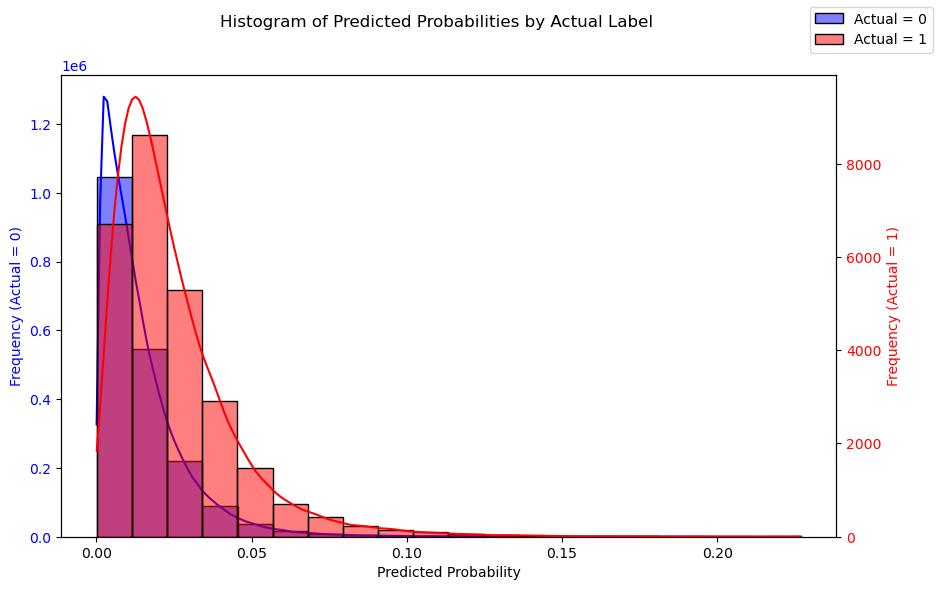

In [ ]:
data = call_center_data.copy()
prob_1 = data[data['Actual'] == 1]['Predicted_Prob']
prob_0 = data[data['Actual'] == 0]['Predicted_Prob']

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.histplot(prob_0, bins=20, color='blue', alpha=0.5, label="Actual = 0", kde=True, ax=ax1)
ax1.set_xlabel("Predicted Probability")
ax1.set_ylabel("Frequency (Actual = 0)", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")


ax2 = ax1.twinx()

sns.histplot(prob_1, bins=20, color='red', alpha=0.5, label="Actual = 1", kde=True, ax=ax2)
ax2.set_ylabel("Frequency (Actual = 1)", color="red")
ax2.tick_params(axis='y', labelcolor="red")

fig.suptitle("Histogram of Predicted Probabilities by Actual Label")
fig.legend(loc="upper right")

plt.show()